## Xtream AI assignement - Challenge 1

## Purpose
The outcome of this notebook will be a model that predicts a gem's worth based on its characteristics.

## Methodology

I will start reading some online content to make myself an idea of the topic and what usually the caracteristics that define a gem's worth are.



## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:

- consider weighted loss function
- insert clas weights during training
- xboost regressor
- aggiusta corellation matrix drop dei feature dipendenti
- fissa randpm state
- skewed data remoeve outliers

## Results

## Previous works

#### Extracted informations from [GEMO](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones):

"Value and beauty of gemstones depend heavily on the precision and quality of their cuts."
"...type of gemstone and considers various characteristics such as kind, color scheme, form, and weight to estimate its value"
"...The valuation of gemstones depends on multiple factors,
including color, cut, carat weight, and clarity..."

- Regression with Random Forest to predict the price
- train-test % split:  80-20
- Metric: RMSE, used to determine the degree of variation between expected and observed prices
- Shape and weight are factors to keep under observation.

#### Extracted informations from [AEMLA](https://ieeexplore.ieee.org/document/10080618):

-  Metrics: R2score, Low RMSE, MAE values, CV Score
- Linear Regression, Random Forest, Decision Tree Random Forest, Cat-Boost Regressor and XGB Regressor.  
- Faceted diamonds are evaluated based on their color, cut, clarity, and carat weight to assess their overall quality
- The two most important aspects of a product are its weight and its color

## Dataset Description

In this section, I have summarized some additional research and responded to questions that have arisen from the data I received.

| Feature       | Description                                      |
|-------------|--------------------------------------------------|
| carat       | Weight of the diamond (1 carat = 200mg)          |
| cut         | Cut quality (to maximize light performance ~ sparkle) |
| color       | [GIA](https://www.gia.edu/gia-about/4cs-color) Color grade                                   |
| clarity     | Clarity grade                                    |
| depth       | The z-depth of the diamond (as a percentage of z)|
| table       | The table-width of the diamond's top (as a percentage of x) |
| price       | Diamonds price (probably in USD as in [stonealgo](https://www.stonealgo.com/diamond-prices/))                                  |
| x           | Width  (in mm / if round, is the diameter)       |
| y           | Length  (in mm)                                  |
| z           | Depth   (in mm)                                  |

#### Color scale values meaning:
From D(Colorless-HIGH QUALITY) to Z(Light Yellow-LOW QUALITY).

#### Clarity scale values meaning:
- FL - Flawless
- VVS1 - Very, very slightly included, first degree
- VVS2 - Very, very slightly included, second degree
- VS1 - Very slightly included, first degree
- VS2 - Very slightly included, second degree
- SI1 - Slightly included, first degree
- SI2 - Slightly included, second degree.
- I1 - Included Diamonds, first degree.

Typical diamonds dimension range : [4 mm, 11 mm].

Since depth is derived from the z and z-depth dimensions, and table is derived from table-width and x, they might not provide additional unique information beyond what is already captured by the original dimensions (Keep an eye on this).

## Library import


In [274]:
#!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset Exploration

In [275]:
diamonds_df=pd.read_csv('diamonds.csv')
print(diamonds_df)
print(diamonds_df.describe())

      carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30      Ideal     H    VVS1   61.2   57.0    655  4.30  4.39  2.66

[5000 rows x 10 columns]
             carat        depth        table        price     



What is visible here is that some 'xyz' dimension are = '0' and 'prices' reach '-1' values.

I might need to remove NULL values for the dimensions and the negative values for the prices since those are nonsensical.


What reasons could be behind negative and null values?
- 1) If the diamond is round, the y dimension might be null.
- 2) negative price? Cannot think of a logical reason.





In [276]:
#Divide numerical features from categorical ones
numerical_features = diamonds_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = diamonds_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'Numerical_features: ',numerical_features,'\nCategorical features: ',categorical_features)

Numerical_features:  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'] 
Categorical features:  ['cut', 'color', 'clarity']


## Numerical features overview

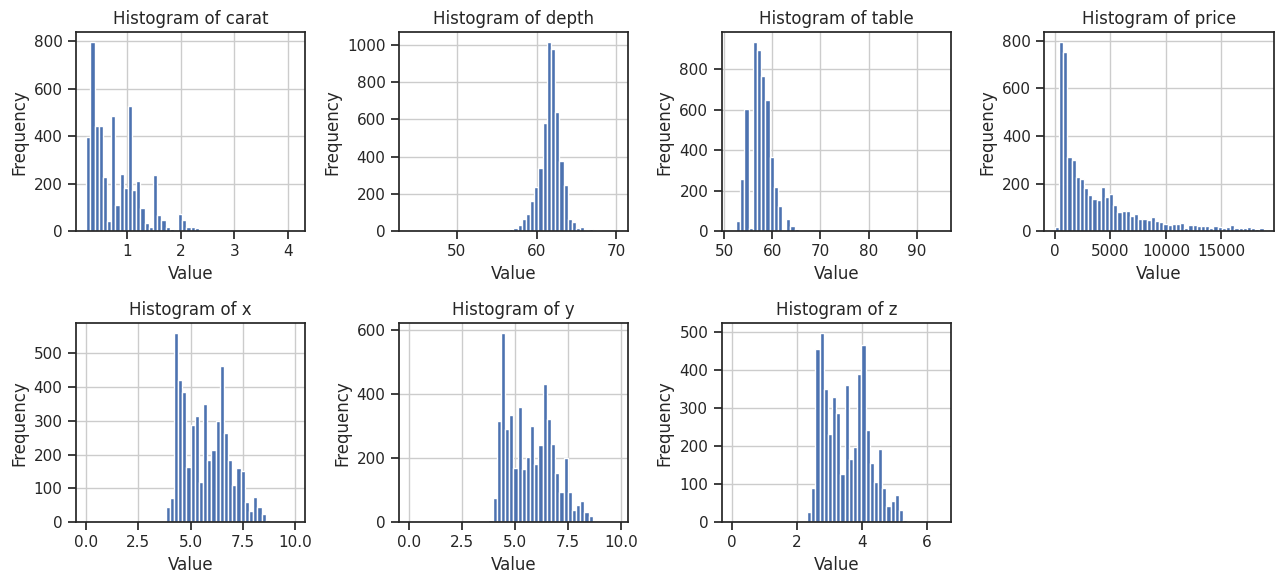

In [277]:
# histograms for numerical features
plt.figure(figsize=(13, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    diamonds_df[feature].plot(kind='hist', title=f'Histogram of {feature}', bins=50)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

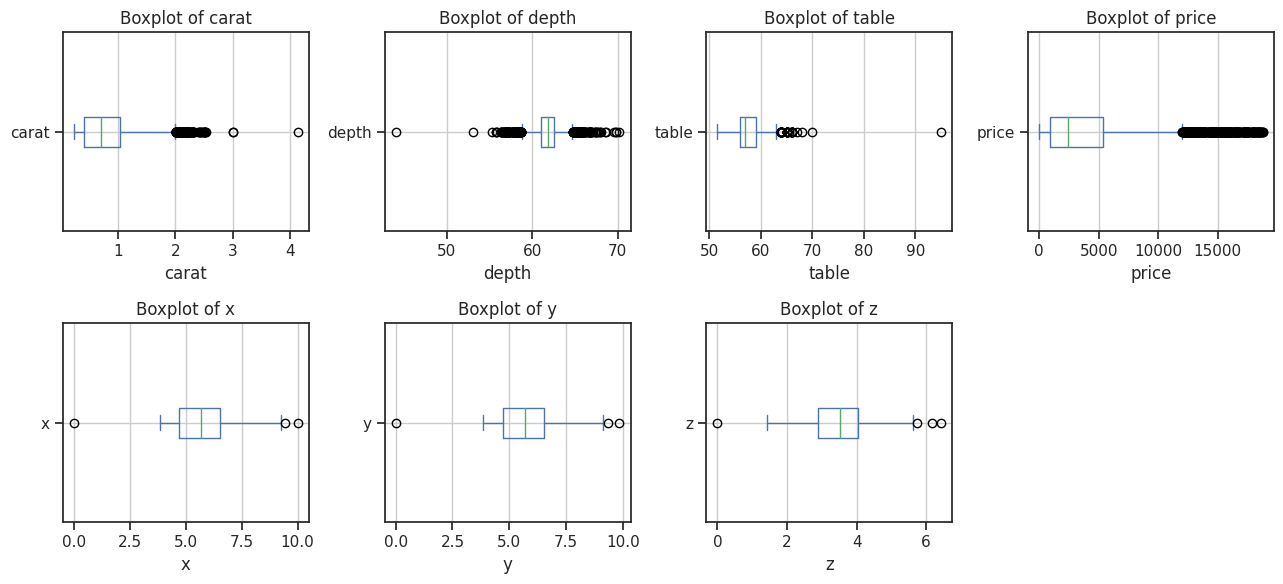

In [278]:
#boxplot for numerical features
plt.figure(figsize=(13, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    diamonds_df[feature].plot(kind='box', title=f'Boxplot of {feature}', vert=False)
    plt.xlabel(feature)
    plt.grid(True)
plt.tight_layout()
plt.show()

Seems like the null dimension rows are a very low amount.

In [279]:
# Count rows where 'x' and 'y' are equal to 0
count_zero_x = len(diamonds_df[(diamonds_df['x'] == 0) ])
count_zero_y = len(diamonds_df[(diamonds_df['y'] == 0) ])
print(count_zero_x, count_zero_y)

# Select rows with values equal to 0
null_df= diamonds_df[(diamonds_df == 0).any(axis=1)]
null_df

1 1


,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


The intuition about the round diamond is not verified: there is only one entry with 'x' and 'y' values equal to 0.


It is possible to remove it since it will not affect much the overall dataset distribution.

In [280]:
#Delete rows with values =0
diamonds_df = diamonds_df[~(diamonds_df == 0).any(axis=1)]
len(diamonds_df)

4999

Remove the duplicate entries if exist.

In [281]:
duplicates = diamonds_df[diamonds_df.duplicated()]

diamonds_df = diamonds_df.drop_duplicates()
print(duplicates,'\n', diamonds_df)

      carat      cut color clarity  depth  table  price     x     y     z
4943   0.31  Premium     E     VS2   61.6   59.0    872  4.35  4.32  2.67 
       carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30   

In [282]:
# Check negative price rows
neg_price = diamonds_df[diamonds_df['price'] <= 0]
neg_price

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [283]:
diamonds_df = diamonds_df.drop(neg_price.index)
len(diamonds_df)

4988

## Categorical Features overview

 Categorial features countplots are shown below.

 Since the categorical features are all ordered, I apply the label encoding technique to transform the categorical values to ordered numerical ones.

 I assign lower quality to lower values.

 Bins are ordered accordingly to the corresponding scale.

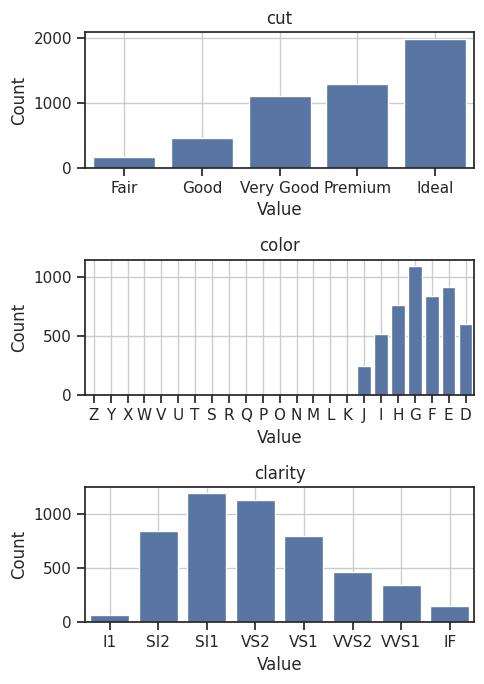

In [284]:
# Countplot for categorical features
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = reversed([chr(i) for i in range(ord('D'), ord('Z')+1)])
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1','IF']

diamonds_df['cut'] = pd.Categorical(diamonds_df['cut'], categories=cut_order, ordered=True)
diamonds_df['color'] = pd.Categorical(diamonds_df['color'], categories=color_order, ordered=True)
diamonds_df['clarity'] = pd.Categorical(diamonds_df['clarity'], categories=clarity_order, ordered=True)

plt.figure(figsize=(5, 7))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 1, i + 1)
    sns.countplot(data=diamonds_df, x=feature)
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [285]:
#Compute percentage of 'Ideal' class in 'cut' feature
filtered_data = diamonds_df[diamonds_df['cut'] == 'Ideal']
len(filtered_data)/len(diamonds_df)

0.3983560545308741

All the categorical features are inbalanced (class frequencies are uneven), we might need to weight the loss.

For the 'cut' feature the Ideal class occupies the 40% of the data

For the 'color' feature the most frequent class is G ( Near Colorless)

For the 'clarity' feature the most frequent classes are VS2 - Very slightly included, second degree and SI1 - Slightly included, first degree.

TODO check how to solve this or ignore this

Actually apply the encoding of the categorical features to the dataframe

In [286]:
diamonds_df['cut'] = diamonds_df['cut'].cat.codes
diamonds_df['color'] = diamonds_df['color'].cat.codes
diamonds_df['clarity'] = diamonds_df['clarity'].cat.codes
diamonds_df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,4,18,1,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,4,18,2,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,3,17,2,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,4,20,2,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,2,20,3,61.7,57.0,4493,6.17,6.21,3.82
...,...,...,...,...,...,...,...,...,...,...
4995,0.38,4,18,5,62.3,53.3,832,4.65,4.69,2.91
4996,0.33,3,19,5,61.3,59.0,927,4.45,4.42,2.72
4997,1.25,4,16,5,62.1,56.0,5980,6.81,6.84,4.24
4998,0.31,3,20,3,62.9,58.0,802,4.31,4.27,2.70


## Scatterplots and correlation

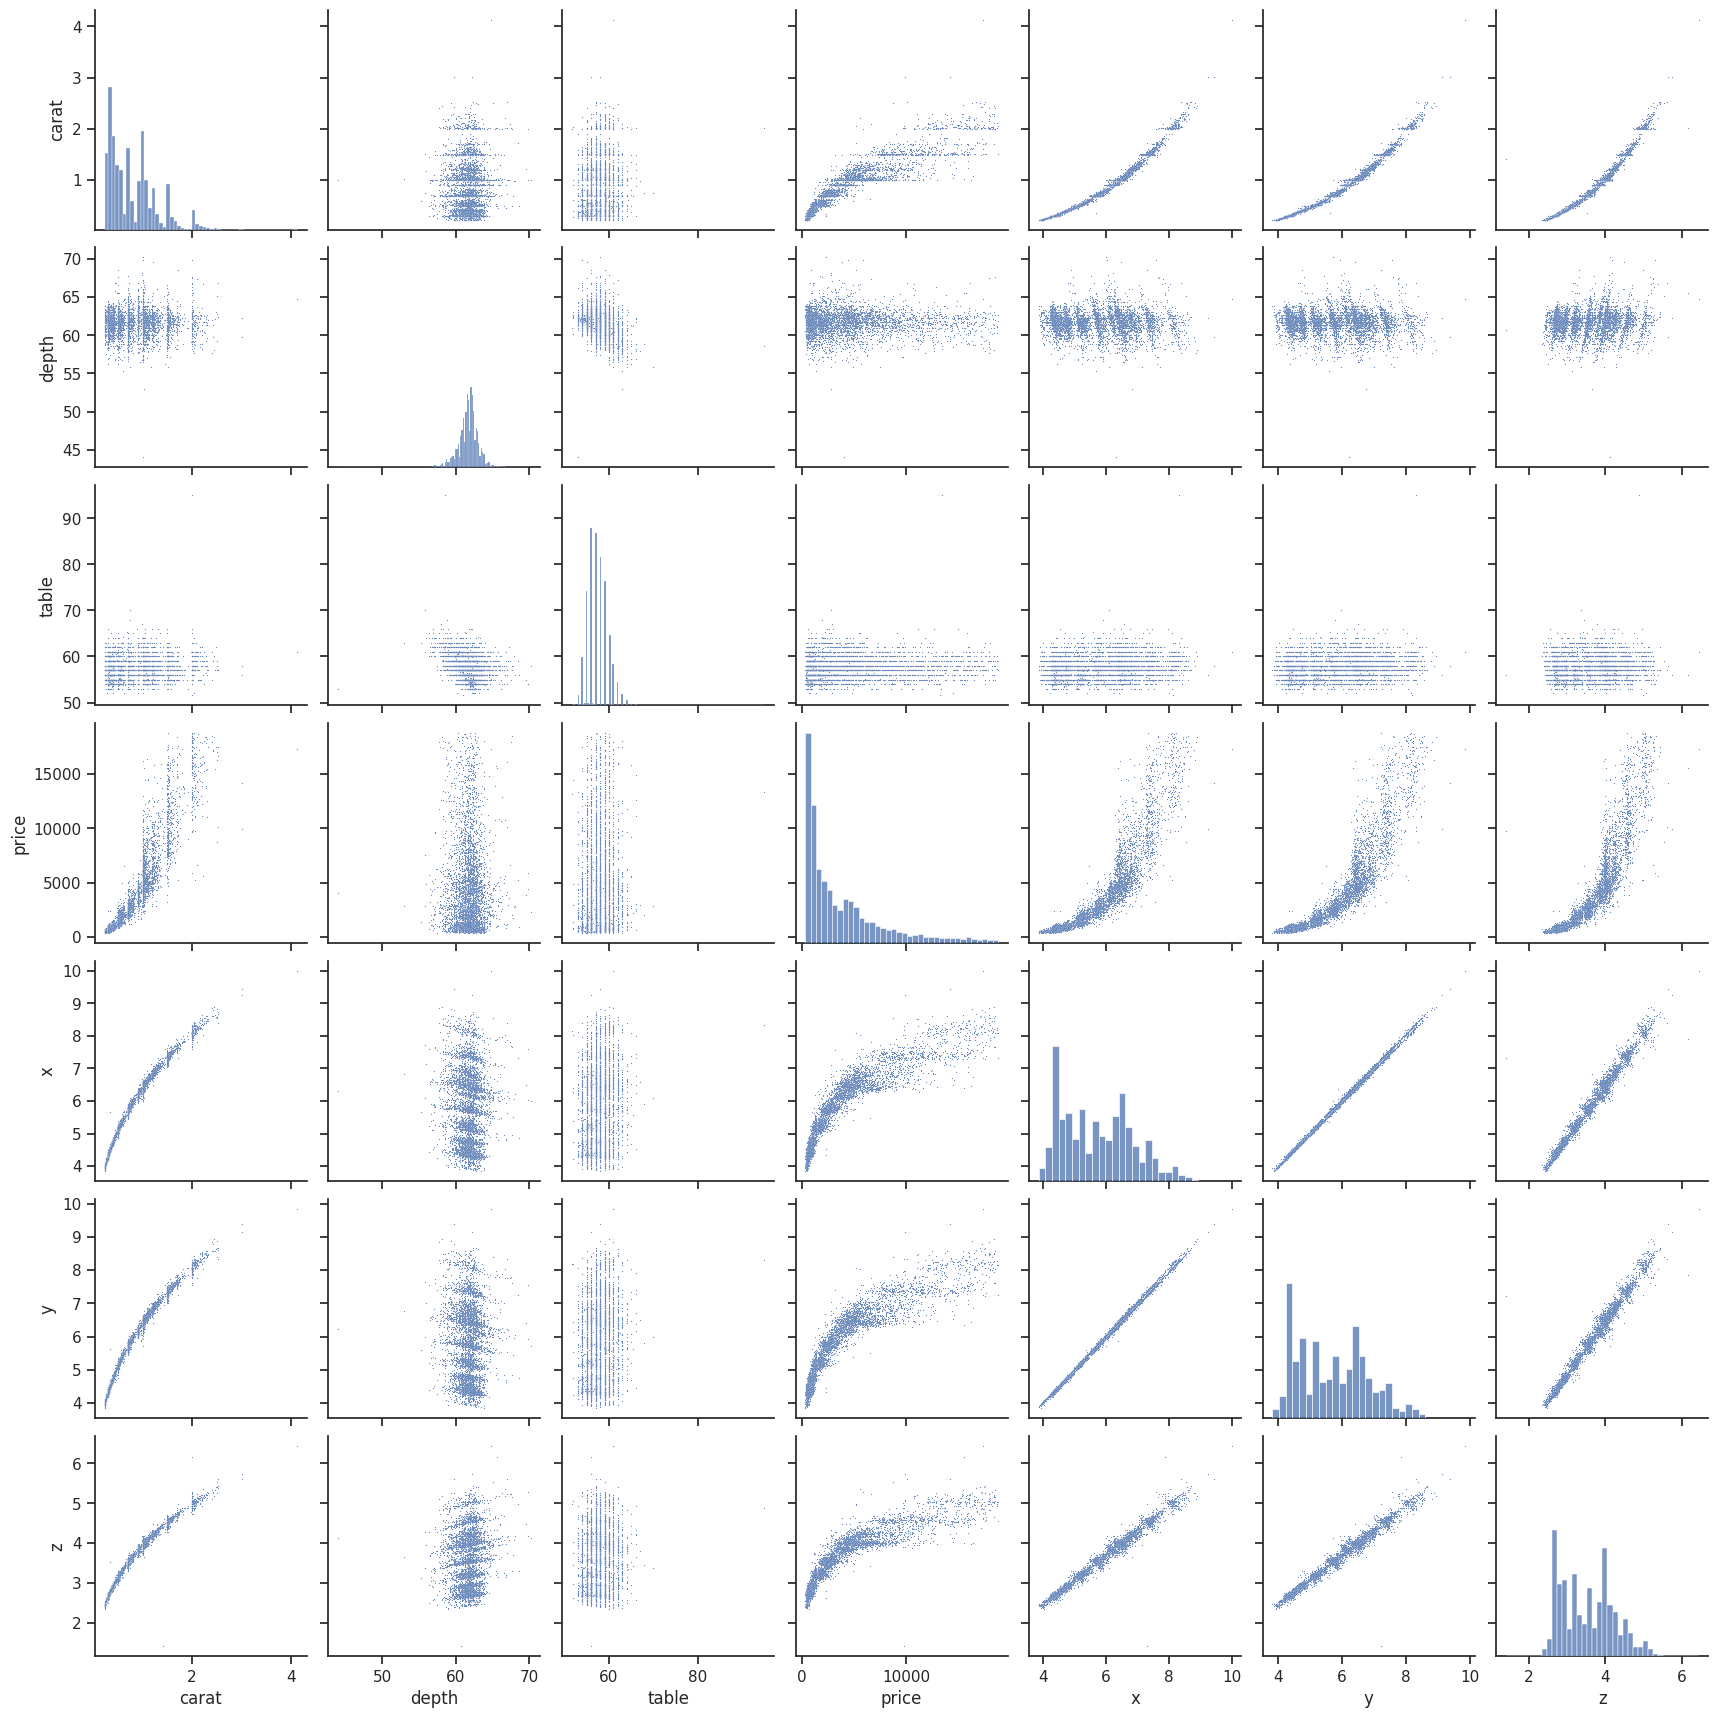

In [287]:
#for ui reasons only plot numerical for now
numerical_df = diamonds_df.drop(categorical_features, axis=1)

marker_size = 0.7
sns.pairplot(numerical_df, plot_kws={'s': marker_size})
plt.show()

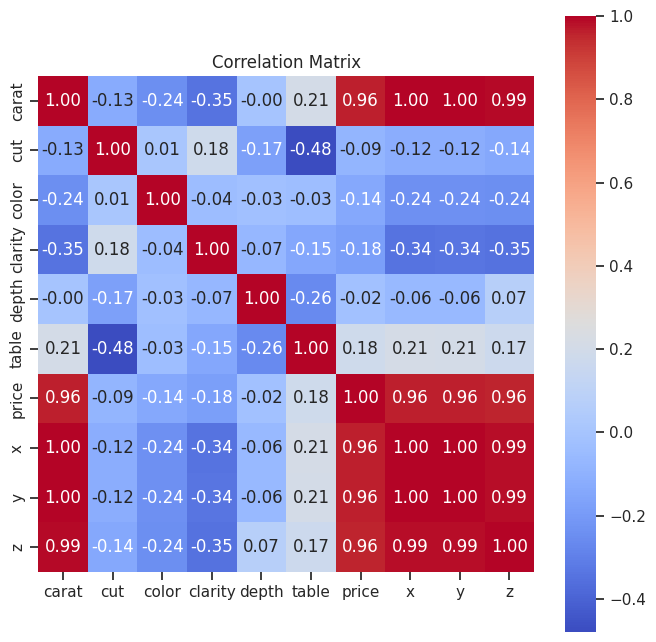

In [288]:
#Correlation matrix
correlation_matrix = diamonds_df.corr(method='spearman')

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In the plot above, the correlation between features is shown.

Correlation values above 0.8 are considered as an index of strong positive correlation between two variables.

We observe that:
- carat is strongly positively correlated to x,y,z, dimensions. It makes sense since the carat represent the weight of the diamond, bigger dimension implies higher weight (with same density).
- Dimensions are strongly correlated each other.
- Price is strongly correlated to carat.
- Is curios that table and depth are not strongly correlated to x and z.

In conclusion x,y,z, can be removed from the dataset

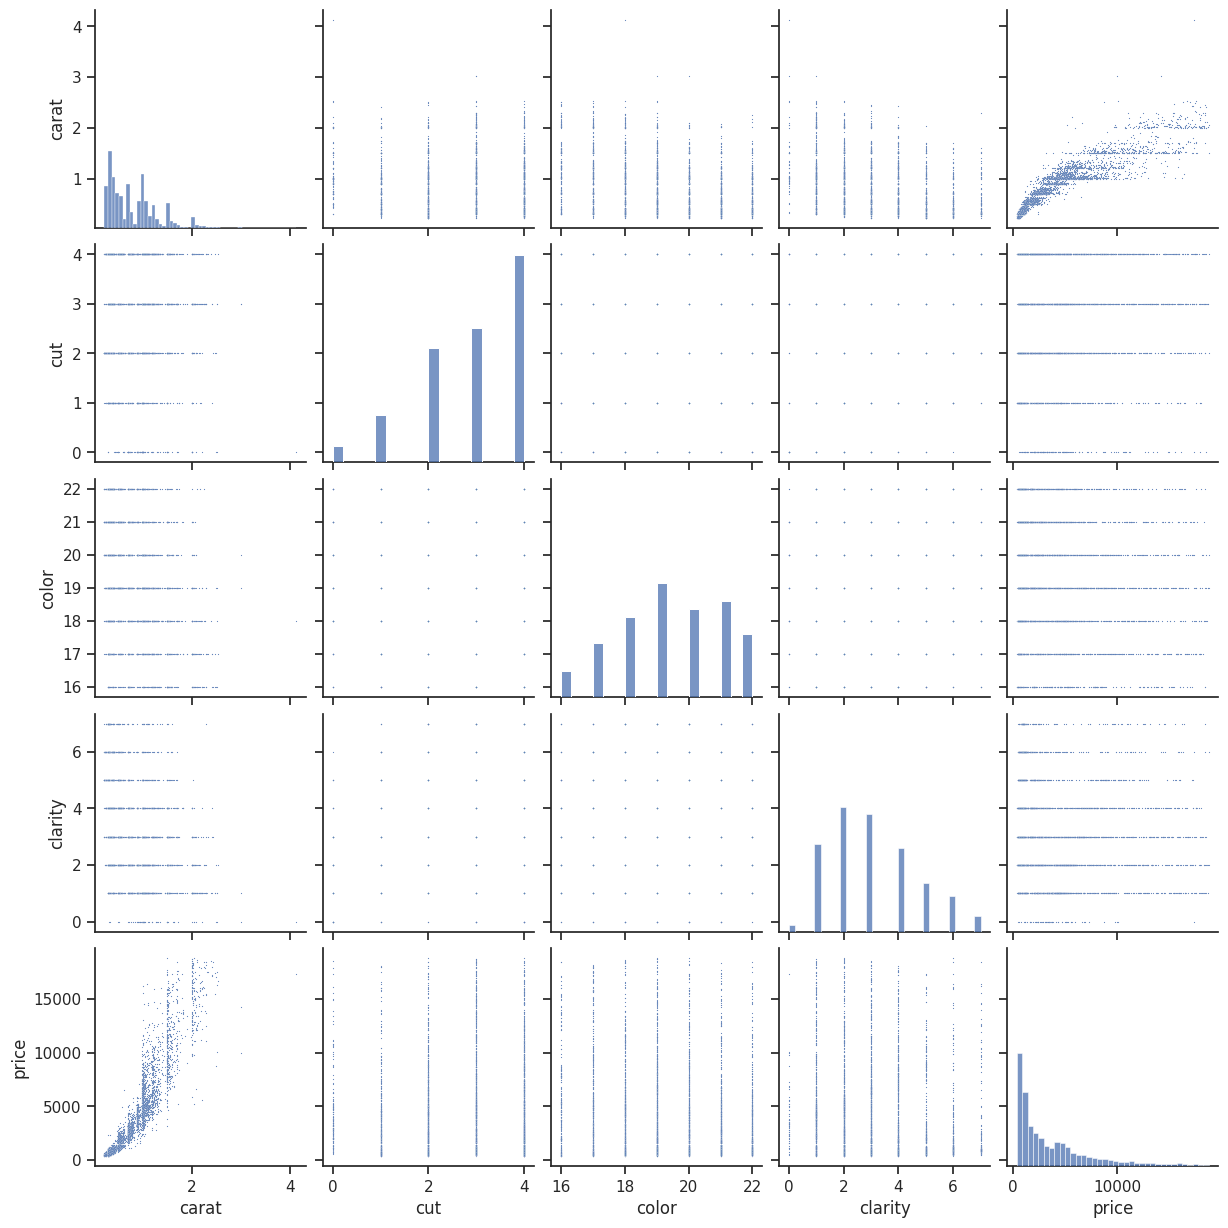

In [291]:
# remove x,y,z,
reduced_diamonds_df = diamonds_df.drop(['x', 'y', 'z'], axis=1)
categ_df = reduced_diamonds_df.drop(['table','depth'], axis=1)
# plot the categorical features vs price
marker_size = 0.7
sns.set(style="ticks")
sns.pairplot(categ_df, plot_kws={'s': marker_size})
plt.show()

to do

not visible correlation with this features

## Price vs Carat

At some point, the strong correlation between carat and price is lost, after 2.5, the carat dimension is dispersed, we can see outliers

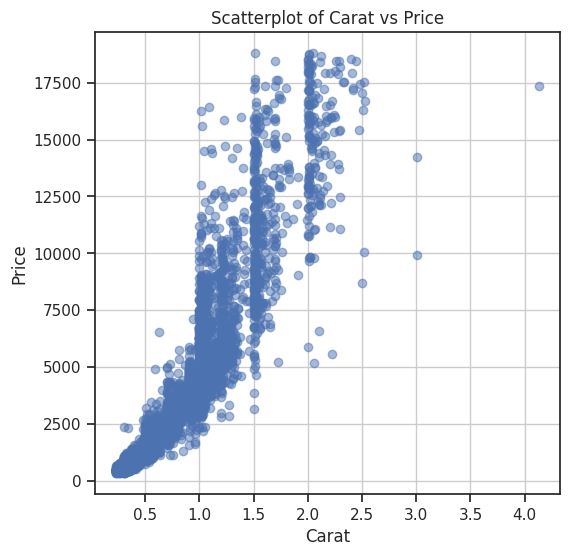

In [295]:
# Create a scatterplot
plt.figure(figsize=(6,6))
plt.scatter(diamonds_df['carat'], diamonds_df['price'], alpha=0.5)
plt.title('Scatterplot of Carat vs Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)
plt.show()

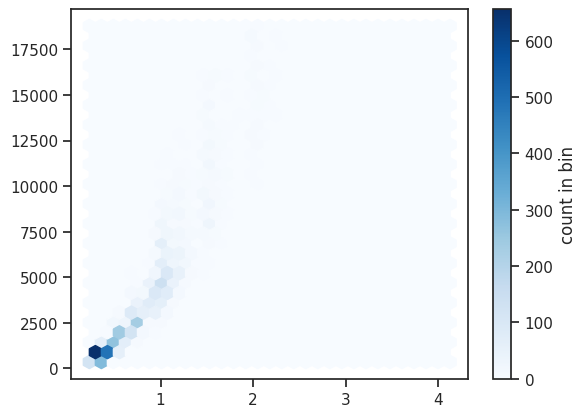

In [296]:
plt.hexbin(diamonds_df['carat'], diamonds_df['price'], gridsize=30, cmap='Blues')
cb = plt.colorbar(label='count in bin')

correlated data in very dense for carat < 1

PVALUE

zvalue

REMOVE OUTLIERS

In [ ]:
diamonds_df.to_csv('diamonds.csv', index=False)

## Clean and preprocess the data





Dataset split to test the performances of the model:

- 80% training
- 20% test to perform an evaluation that simulated realworld scenarios

## EVALUATION METRICS
RMSE
plotta grafico con actual vs predicted e riga bisettrice
sulla x e la y i prezzi attuali e predetti

# References:

[GEMO](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones) S, Senarathne & Epitawatta, Kanjana & Thennakoon, Kusalani & W, Diunugala & Rathnayake, H. & Madhuhansi, M.. (2023). “Gemo”: An AI-Powered Approach to Color, Clarity, Cut Prediction, and Valuation for Gemstones. International Research Journal of Innovations in Engineering and Technology. 07. 406-416. 10.47001/IRJIET/2023.710054.

[AEMLA](https://ieeexplore.ieee.org/document/10080618) M. S. A. Basha, P. M. Oveis, C. Prabavathi, M. B. Lakshmi and M. M. Sucharitha, "An Efficient Machine Learning Approach: Analysis of Supervised Machine Learning Methods to Forecast the Diamond Price," 2023 International Conference for Advancement in Technology (ICONAT), Goa, India, 2023, pp. 1-6, doi: 10.1109/ICONAT57137.2023.10080618.
2. author2, article2, journal2, year2, url2